## 7.100 Beyond the Sequential model

So far we have seen models with a stacked chain of layers

A single input - a chain of in-out processing layers, and a single output

Very common but too inflexible for many interesting tasks 

###### Multi-input tasks

Predict the price of second-hand clothing from: metadata (item brand, age...), text description and a picture

A single output (price) but several inputs

Input data is varied - numerical data, text and image

Metadata modeled by a dense module

Text data modeled by an RNN

Image data modelled by a convnet

The models could be run independently and the outputs averaged but there could be redundancy between the models 

Better to merge the three models in a multi-input graph architecture

The joint model is trained and redundancy is minimised

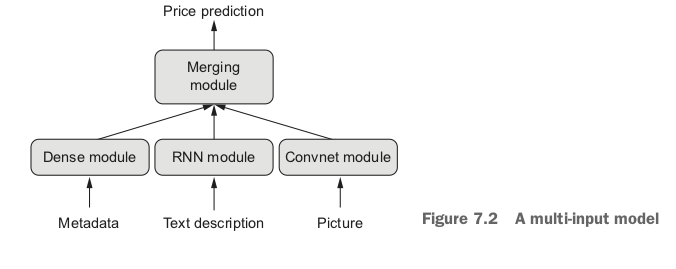

###### Multi-output tasks

For example, a text might be classified by genre and by year of publication

The former is a multiclass task, the latter is a regression problem

But the two tasks share information - either might help the other - so a text processing layer could feed a genre classifier and a date regressor

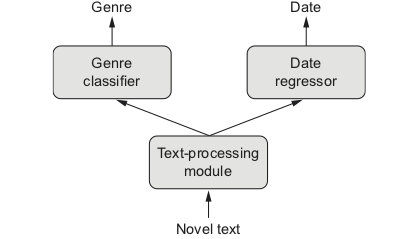

##### Acyclic graphs

Many state-of -the-art neural architectures are acyclic graphs

Inception and residual architectures where input splits into several parallel branches before merging 

Inception architecture

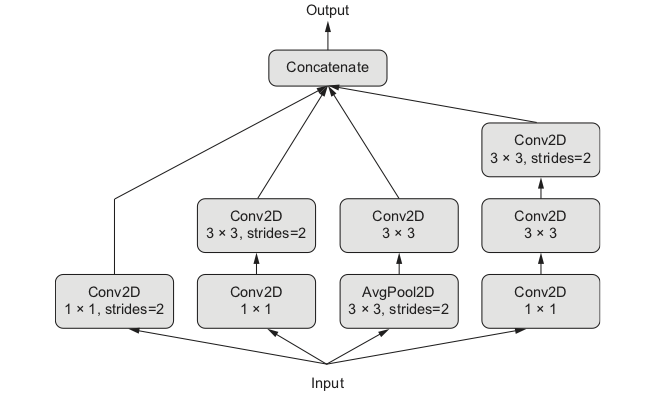

Resdual connection

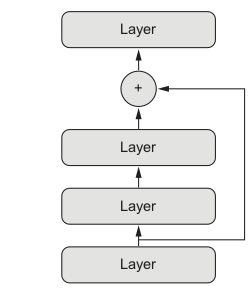

Multi-input/output and graph architectures aren't possible with sequential `tensorflow.keras` layers

The functional API enables arbitrary acyclic architectures 

----

## 7.110 The functional API

Layers are functions, mapping tensors to tensors

In [1]:
import tensorflow.keras as keras
from tensorflow.keras import Input, layers

input_tensor = Input(shape = (32,)) # a tensor
dense = layers.Dense(32, activation = 'relu') # a layer as a function
output_tensor = dense(input_tensor) # a layer is called on a tensor and returns a tensor

Python functional programming example:

In [2]:
def f(x):
    def g(y):
        return x * y
    return g

func = f(7)
print(f(7)(2), func(2))

14 14


Here is a minimal model, written in both styles:

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, Input

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(1)(x)

model = Model(input_tensor, output_tensor)

In [3]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,169
Trainable params: 3,169
Non-trainable params: 0
_________________________________________________________________


Compiling, training and evaluating proceed as before

Let's see if we can train an ANN to add numbers

In [4]:
model.compile(optimizer='rmsprop', loss='mse', metrics = ['mae'])

import numpy as np
x_train = np.random.random((50000, 64))
x_test = np.random.random((10000, 64))

y_train = np.sum(x_train, axis = 1)
y_test = np.sum(x_test, axis = 1)

model.fit(x_train, y_train, epochs=100, batch_size=128)

Epoch 1/100
391/391 [==============================] - 0s 698us/step - loss: 86.5522 - mae: 4.1365
Epoch 2/100
391/391 [==============================] - 0s 700us/step - loss: 0.1482 - mae: 0.3581
Epoch 3/100
391/391 [==============================] - 0s 709us/step - loss: 0.1360 - mae: 0.3552
Epoch 4/100
391/391 [==============================] - 0s 703us/step - loss: 0.1320 - mae: 0.3506
Epoch 5/100
391/391 [==============================] - 0s 704us/step - loss: 0.1307 - mae: 0.3517
Epoch 6/100
391/391 [==============================] - 0s 701us/step - loss: 0.1284 - mae: 0.3490
Epoch 7/100
391/391 [==============================] - 0s 729us/step - loss: 0.1260 - mae: 0.3471
Epoch 8/100
391/391 [==============================] - 0s 837us/step - loss: 0.1246 - mae: 0.3454
Epoch 9/100
391/391 [==============================] - 0s 830us/step - loss: 0.1233 - mae: 0.3447
Epoch 10/100
391/391 [==============================] - 0s 732us/step - loss: 0.1224 - mae: 0.3439
Epoch 11/100
391/3

In [5]:
test_mse, test_mae  = model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 527us/step - loss: 0.0602 - mae: 0.2439


Has our model beaten a common-sense baseline?

The average of 64 random numbers between 0 and 1 is about 32:

In [6]:
np.average(abs(y_test - 32))

1.8589681318338913

----

## 7.120 Multi-input models

Build several models and merge them, for example with `layers.add, layers.concatenate`

Suppose we wish to build a model to answer questions on text

The inputs are a question and a text snippet that provides information for finding a one-word answer
 
We require a two-input, single output network

In [ ]:
# text model
embedded_text = layers.Embedding(64, text_vocab_size)(text_input)
encoded_text = layers.LTSM(32)(embedded_text)

# question model
embedded_question = layers.Embedding(32, question_vocab_size)(question_input)
encoded_question = layers.LTSM(16)(embedded_question)

# merge models
concatenated = layers.concatenate([encoded_text, encoded_question], axis=-1)

# classifier
answer = layers.Dense(answer_vocab_size, activation='softmax')(concatenated)
         
# final model
model = Model([text_input, question_input], answer)

----

## 7.130 Multi-output models

Build a single base and then place several layers on top

E.g. suppose you wish to predict age, income and gender from a single text (e.g. a social media post) 

In [ ]:
embedded_posts = layers.Embedding(256, vocab_size)(posts_length)

# base
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
...
x = layers.Dense(128, activation='relu')(x)

In [ ]:
# three top-level classifiers
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups, activation='softmax', name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

# final model
model = Model(post_input, [age_prediction, income_prediction, gender_prediction])

The gradient descent algorithm requires a scalar function, not three losses

- mse (age), $f_1$
- binary crossentropy (gender), $f_2$
- categorical crossentropy (income group), $f_3$

One solution is to sum the three losses: $f_{loss} = f_1 + f_2 + f_3$
    - losses are in different ranges 
    - network might focus on the task with the largest individual loss 

The losses can be balanced by *weighting*: $f_{loss} = \sum_i \alpha_i f_i$

----

### 7.140 Directed acylic graphs of layers

Keras functional model building is not limited to multiple inputs and outputs

Graphs with complex internal topology are possible - as long as there are no cycles

For example, the popular *Inception* architecture

This type of network has several parallel branches

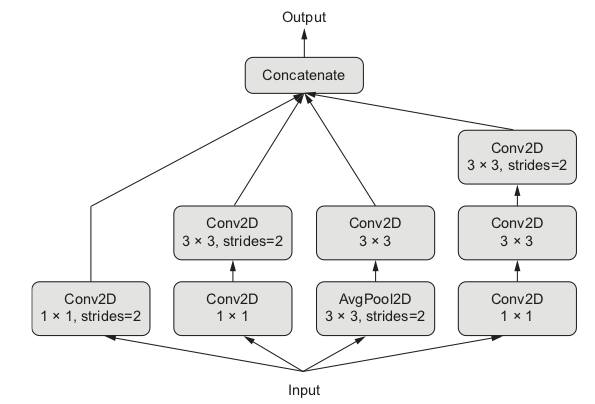

In [ ]:
x = tf.zeros([10, 128, 128, 3])
branch_a = layers.Conv2D(128, 1, activation = 'relu', strides = 2)(x)

branch_b = layers.Conv2D(128, 1, activation = 'relu')(x)
branch_b = layers.Conv2D(128, 3, activation = 'relu', strides = 2)(branch_b)

branch_c = layers.AveragePooling2D(3, strides=2)(x)
branch_c = layers.Conv2D(128, 3, activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, activation = 'relu')(x)
branch_d = layers.Conv2D(128, 3, activation = 'relu')(branch_d)
branch_d = layers.Conv2D(128, 3, activation = 'relu', strides=2)(branch_d)

output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], axis=-1)

The Inception architecture is available in keras as `keras.applications.inception_v3.InceptionV3` and includes ImageNet trained weights


Xception is an extreme Inception model, designed by F. Chollet
    - fully separates spatial and channel-wise features
    - has the roughly the same capacity as Inception V3 
    - but is more efficient and performs better

##### Residual connections

A residual connection is a link between an earlier and a later layer

The earlier layer output is added to the later layer output:

In [ ]:
x = ...
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

y = layers.add([y, x])

The Xception model is a linear stack of convolution layers with residual connections

Residual connections address two problems
    1. information bottlenecks 
    2. vanishing gradients

1. Information bottlenecks

The representational power of a layer is limited by its size

Information can get lost in the processing pipeline - for example, high frequency information can never be recovered by later layers if there is a low pass filter early on 

Residual connections re-inject the higher information content of earlier layer outputs.

2. Vanishing gradients 

Backpropagation is simply the application of the chain rule 

Suppose layer 1 is the top layer, layer 2 is the first hidden layer from the top etc, the gradient of the loss with respect to a weight in layer 8 is:

$
\frac{df_{loss}}{dW_{8}} = \frac{df_{loss}}{dL_{layer 1}}\frac{dL_{layer 2}}{dL_{layer 3}}\frac{dL_{layer 3}}{dL_{layer 4}}\ldots\frac{dL_{layer 8}}{dW_8}
$

A product of layer gradients $\frac{dL_i}{dL_{i+1}}$

The combined product can get very small if the layer gradients have absolute value less than 1

The LSTM 'carry' propagates information forward in time and helps avoid vanishing gradients in recurrent networks

The residual connection has a similar effect in deep feedforward nets

----

## 7.150 Layer weight sharing

A layer instance can be reused with identical weights.

Build models with shared branches - the branches have the same knowledge and perform the same operations



Consider a model that compares two sentences for semantic similarity

The model has two inputs and a single output in the interval $[0, 1]$

This model would be useful in a natural language dialogue system 

But similarity is symmetric: 

If sentence A is similar to sentence B, then B is similar to A

No need to train two independent models

Instead use a shared LSTM

LSTM weights are trained on both inputs simultaneously

In [ ]:
lstm = layers.LSTM(32)

left_input = Input(shape=(None, 128))
left_ouput = lstm(left_input)

right_input = Input(shape=(None, 128))
right_output = lstm(right_input)

merged = layers.concatenate([left_ouput, right_ouput], axis=-1) # final axis
predictions = layers.Dense(1, activation='sigmoid')(merged)

model = Model([left_input, right_input], predictions)

----

## 7.160 Models as layers

Layers, in the functional approach, accept tensors and output tensors

Just like models! 

The functional API treats models as it treats layers

Consider stereographic computer vision

We shouldn't need separate models for left and right cameras

Instead, we can share two Xception bases

The Xception base weights are trained on the left and right inputs simultaneously

In [ ]:
xception_base = applications.Xception(weights='none', include_top=False)

left_featrues = xception_base(left_input)
right_features = xception_base(right_input)

merged_features = layers.concatenate([left_features, right_features], axis=-1)

----


## 7.170 Wrapping up

- The `Sequentional` api is limited to a single input, pipeline and output
- Multiple input/output models, models with parallel branches and models with residual connections all require the functional api
- The weights of a layer or model can be reused across several processing branches by calling the same layer or model instance several times

----